# **Imports**

In [1]:
import re
import numpy as np
from matplotlib import pyplot as plt

# **Data Processing**

In [3]:
# loading dataset
train_data = open('data/character/train.txt', 'r').read()
test_data = open('data/character/test.txt', 'r').read()
valid_data = open('data/character/valid.txt', 'r').read()

In [4]:
# clean data by removing unnecessary substrings
def clean_data(datax):
  datax = datax.replace('< u n k >', '').replace('\n', '_').replace(' ', '')
  datax = re.sub(r'[^a-z_]', '', datax)
  datax = re.sub('_{2,}', '_', datax)
  return datax

train_data = clean_data(train_data)
test_data = clean_data(test_data)
valid_data = clean_data(valid_data)

In [5]:
vocab_chars = list(set(train_data))
vocab_size = len(vocab_chars)
char2idx = { ch:i for i,ch in enumerate(vocab_chars) }
idx2char = { i:ch for i,ch in enumerate(vocab_chars) }
print(f'Number of unique characters is {vocab_size}')

Number of unique characters is 27


In [6]:
def encode_sequence(sequence, inp_size):
    seq_encoding = {}
    for i in range(len(sequence)):
        one_hot = np.zeros((inp_size,1))
        one_hot[char2idx[sequence[i]]] = 1.0
        seq_encoding[i] = one_hot
    return seq_encoding

In [7]:
def data_generator(datax, inp_size=27, seq_len=100, batch_size=128):
    """
    generates 1 batch of inputs
    1 batch = 128 sequences
    1 sequence = 50 time points / samples
    1 sample = 27 feature values
    inputs shape: (128, 50, 27) or (batch_size, seq_len, num_features)
    targets shape: (128, 50, 27), 1 target value for each sample, many-to-many architecture
    """
    inputs, targets = {}, {}
    seq_len += 1 # because input = [0:seq_len-1), target = [1:seq_len)
    start = 0 # where to start drawing inputs, incremented by batch size * seq_len
    while True:
        if start + batch_size * seq_len > len(datax):
            start = 0
        stop = start + batch_size * seq_len
        indices = np.arange(start, stop, seq_len)
        for i in range(len(indices)):
            sequence = datax[indices[i]:indices[i]+seq_len]
            inputs[i] = encode_sequence(sequence[:-1], inp_size)
            targets[i] = encode_sequence(sequence[1:], inp_size)
        start += batch_size * seq_len
        yield inputs, targets

In [9]:
# train_gen = data_generator(train_data, vocab_size, seq_len, batch_size)
# test_gen = data_generator(test_data, vocab_size, seq_len, batch_size)
# val_gen =  data_generator(valid_data, vocab_size, seq_len, batch_size)

# train_steps = len(train_data)//((seq_len+1)*batch_size)
# test_steps = len(test_data)//((seq_len+1)*batch_size)
# val_steps = len(valid_data)//((seq_len+1)*batch_size)

# print(f'Number of batches for train: {train_steps}')
# print(f'Number of batches for test: {test_steps}')
# print(f'Number of batches for validation: {val_steps}')

# **Functions**

In [10]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

In [11]:
def gradient_clip(grads, max_norm, order=1):
    total_norm = 0.0
    if order > 1:
        for i in range(order):
            total_norm += np.linalg.norm(grads[0][-i-1])
    else:
        total_norm += np.linalg.norm(grads[0])
    for i in range(1, len(grads[1:])):
        total_norm += np.linalg.norm(grads[i])
    
    total_norm = np.sqrt(total_norm)
    if total_norm > max_norm:
        if order > 1:
            for i in range(order):
                grads[0][-i-1] *= max_norm / total_norm
        else:
            grads[0] *= max_norm / total_norm
        for i in range(1, len(grads[1:])):
            grads[i] *= max_norm / total_norm
    """
    # andrej
    for i in range(len(grads)):
        np.clip(grads[i], -5, 5, out=grads[i]) # clip to mitigate exploding gradients
    """
    return grads

In [12]:
def find_loss(outputs, targets):
    loss = 0.0
    for n in range(len(outputs)):
        for t in range(len(outputs[n])):
            loss += -np.log(outputs[n][t][np.argmax(targets[n][t])])
    loss /= len(outputs)
    return loss

In [13]:
def find_acc(outputs, targets):
    acc = 0.0
    for n in range(len(outputs)):
        for t in range(len(outputs[n])):
            acc += np.argmax(targets[n][t]) == np.argmax(outputs[n][t])
    acc /= len(outputs[0])
    acc /= len(outputs)
    return acc

In [14]:
def update_parameters(params, grads, lr, order=0):
    if order > 1:
        for i in range(order):
            params[0][-i-1] -= grads[0][-i-1] * lr
    else:
        params[0] -= grads[0] * lr
    for i in range(1, len(params[1:])):
        params[i] -= grads[i] * lr
    return params

# **Vanilla RNN**

In [15]:
class RNN():
    def __init__(self, hidden_size, input_size, out_size):
        V = np.random.randn(hidden_size, hidden_size)*0.1 # W_hh
        U = np.random.randn(hidden_size, input_size)*0.1  # W_hx
        W = np.random.randn(out_size, hidden_size)*0.1    # W_hy
        b_hidden = np.zeros((hidden_size, 1))              # b_h
        b_out = np.zeros((out_size, 1))                    # b_y
        self.params = [V, U, W, b_hidden, b_out]
        self.best = [V, U, W, b_hidden, b_out]
    
    def forward(self, inputs, hidden_state, best=False):
        if best: 
            V, U, W, b_hidden, b_out = self.best    
        else: 
            V, U, W, b_hidden, b_out = self.params
        outputs, hidden_states = {}, {}
        for n in range(len(inputs)):
            outputs[n], hidden_states[n] = {}, {}
            hidden_states[n][-1] = np.copy(hidden_state)
            for t in range(len(inputs[n])):
                hidden_states[n][t] = np.tanh(np.dot(U, inputs[n][t]) + np.dot(V, hidden_states[n][t-1]) + b_hidden)
                outputs[n][t] = softmax(np.copy(np.dot(W, hidden_states[n][t]) + b_out))
        return outputs, hidden_states

    def backward(self, inputs, outputs, hidden_states, targets, clip_norm):
        V, U, W, b_hidden, b_out = self.params
        dV, dU, dW = np.zeros_like(V), np.zeros_like(U), np.zeros_like(W)
        db_hidden, db_out = np.zeros_like(b_hidden), np.zeros_like(b_out)

        dh_next = np.zeros_like(hidden_states[0][0])
        loss = 0.0
        N = len(outputs)
        for n in range(N):
            for t in reversed(range(len(inputs[n]))):
                loss += -np.log(outputs[n][t][np.argmax(targets[n][t])])
                do = np.copy(outputs[n][t])
                do[np.argmax(targets[n][t])] -= 1
                dW += np.dot(do, hidden_states[n][t].T)
                db_out += do
                dh = np.dot(W.T, do) + dh_next
                df = (1 - hidden_states[n][t] * hidden_states[n][t]) * dh
                db_hidden += df
                dU += np.dot(df, inputs[n][t].T)
                dV += np.dot(df, hidden_states[n][t-1].T)
                dh_next = np.dot(V.T, df)
        loss /= N
        dV, dU, dW, db_hidden, db_out = dV/N, dU/N, dW/N, db_hidden/N, db_out/N
        grads = [dV, dU, dW, db_hidden, db_out]
        grads = gradient_clip(grads, clip_norm)
        return loss, grads

    def train(self, train_set, valid_set, hidden_state, num_epochs, lr, clip_norm, train_steps=100, val_steps=100):
        training_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            epoch_training_loss = 0.0
            epoch_validation_loss = 0.0
            min_valid_loss = 1e6

            for train_step in range(train_steps):
                inputs, targets = next(train_set)
                outputs, hidden_states = self.forward(inputs, hidden_state)
                loss, grads = self.backward(inputs, outputs, hidden_states, targets, clip_norm)
                self.params = update_parameters(self.params, grads, lr)
                epoch_training_loss += loss

            for val_step in range(val_steps):
                inputs, targets = next(valid_set)
                outputs, _ = self.forward(inputs, hidden_state)
                loss = find_loss(outputs, targets)
                if loss < min_valid_loss:
                    self.best = self.params.copy()
                    min_valid_loss = loss
                epoch_validation_loss += loss
                    
            training_loss.append(epoch_training_loss/train_steps)
            validation_loss.append(epoch_validation_loss/val_steps)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        return training_loss, validation_loss

    def test(self, test_set, hidden_state, test_steps=100):
        test_loss, test_acc = 0.0, 0.0
        for test_step in range(test_steps):
            inputs, targets = next(test_set)
            outputs, _ = self.forward(inputs, hidden_state, best=True)
            test_loss += find_loss(outputs, targets)
            test_acc += find_acc(outputs, targets)
        test_loss /= test_steps
        test_acc /= test_steps
        print("Test loss: ", test_loss)
        print("Test acc: ", test_acc)
        return test_loss, test_acc

## Train Vanilla RNN

In [18]:
### Train Vanilla RNN ###
# Hyperparameters
hidden_size = 64
gradient_clip_norm = 1.0
learning_rate = 0.01
num_epochs = 30
batch_size = 64
num_exp = 2 # number of experiments

RNN Experiment: 0; seq_len: 5
Epoch 0, training loss: [14.72228218], validation loss: [14.27087866]
Epoch 10, training loss: [11.92575116], validation loss: [11.97578592]
Epoch 20, training loss: [14.1912248], validation loss: [14.19690433]
Test loss:  [14.0552346]
Test acc:  0.19250000000000003
RNN Experiment: 1; seq_len: 5
Epoch 0, training loss: [14.76695949], validation loss: [14.26304455]
Epoch 10, training loss: [13.77750741], validation loss: [13.82448307]


KeyboardInterrupt: ignored

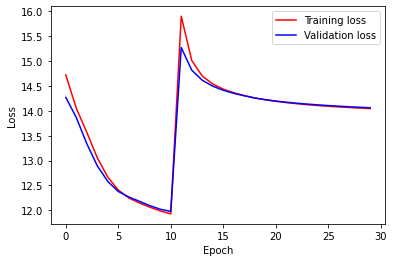

In [19]:
seq_lens = [5, 10, 100]
rnn_test_results = {}

for seq_len in seq_lens:
    train_gen = data_generator(train_data, vocab_size, seq_len, batch_size)
    test_gen = data_generator(test_data, vocab_size, seq_len, batch_size)
    val_gen =  data_generator(valid_data, vocab_size, seq_len, batch_size)

    train_steps = len(train_data)//((seq_len+1)*batch_size)
    test_steps = len(test_data)//((seq_len+1)*batch_size)
    val_steps = len(valid_data)//((seq_len+1)*batch_size)

    rnn_test_results[seq_len] = {}
    test_loss_results, test_acc_results = [], []
    for n in range(num_exp):
        print(f'RNN Experiment: {n}; seq_len: {seq_len}')
        rnn_model = RNN(hidden_size=hidden_size, input_size=vocab_size, out_size=vocab_size)
        hidden_state = np.zeros((hidden_size, 1))  # Initial hidden_state
        train_loss, valid_loss = rnn_model.train(train_set=train_gen, valid_set=val_gen, 
                                                hidden_state=hidden_state, num_epochs=num_epochs, 
                                                lr=learning_rate, clip_norm=gradient_clip_norm, 
                                                train_steps=train_steps, val_steps=val_steps)
        test_loss, test_acc = rnn_model.test(test_set=test_gen, hidden_state=hidden_state, test_steps=test_steps)
        test_loss_results.append(test_loss)
        test_acc_results.append(test_acc)
        # Plot training and validation loss
        epoch = np.arange(len(train_loss))
        plt.figure()
        plt.plot(epoch, train_loss, 'r', label='Training loss',)
        plt.plot(epoch, valid_loss, 'b', label='Validation loss')
        plt.legend()
        plt.xlabel('Epoch'), plt.ylabel('Loss')
        plt.savefig(f'char_{seq_len}_exp_{n}_rnn.png')
    
    print(f'Average char test loss: seq_len: {seq_len}, {np.average(test_loss_results)}')
    print(f'Average char test acc: seq_len: {seq_len}, {np.average(test_acc_results)}')
    rnn_test_results[seq_len]['loss'] = np.average(test_loss_results)
    rnn_test_results[seq_len]['acc'] = np.average(test_acc_results)
    rnn_test_results[seq_len]['all_loss'] = test_loss_results.copy()
    rnn_test_results[seq_len]['all_acc'] = test_acc_results.copy()

# **HORNN**

In [ ]:
class HORNN():
    def __init__(self, hidden_size, input_size, out_size, order):
        self.order = order
        V = {}
        for i in range(self.order):
            V[-i-1] = np.random.randn(hidden_size, hidden_size)*0.1 # W_hh
        U = np.random.randn(hidden_size, input_size)*0.1            # W_hx
        W = np.random.randn(out_size, hidden_size)*0.1              # W_hy
        b_hidden = np.zeros((hidden_size, 1))                        # b_h
        b_out = np.zeros((out_size, 1))                              # b_y
        self.params = [V, U, W, b_hidden, b_out]
        self.best = [V, U, W, b_hidden, b_out]
    
    def forward(self, inputs, hidden_state, best=False):
        if best: 
            V, U, W, b_hidden, b_out = self.best    
        else: 
            V, U, W, b_hidden, b_out = self.params
        outputs, hidden_states = {}, {}
        for n in range(len(inputs)):
            outputs[n], hidden_states[n] = {}, {}
            for i in range(self.order): # for the history window
                hidden_states[n][-i-1] = np.copy(hidden_state)
            for t in range(len(inputs[n])):
                s = np.zeros_like(hidden_state)
                for i in range(self.order): # order = 3: -1, -2, -3; 
                    s += np.dot(V[-i-1], hidden_states[n][t-i-1])
                hidden_states[n][t] = np.tanh(np.dot(U, inputs[n][t]) + s + b_hidden)
                outputs[n][t] = softmax(np.copy(np.dot(W, hidden_states[n][t]) + b_out))
        return outputs, hidden_states

    def backward(self, inputs, outputs, hidden_states, targets, clip_norm):
        V, U, W, b_hidden, b_out = self.params
        dV = {}
        for i in range(self.order):
            dV[-i-1] = np.zeros_like(V[-i-1])
        dU, dW = np.zeros_like(U), np.zeros_like(W)
        db_hidden, db_out = np.zeros_like(b_hidden), np.zeros_like(b_out)

        loss = 0.0
        N, T = len(inputs), len(inputs[0])
        for n in range(N):
            arrayOfM, arrayOfs = {}, {}
            for i in range(self.order):
                arrayOfM[i], arrayOfs[i] = 0.0, 0.0
            for t in reversed(range(len(inputs[n]))):
                loss += -np.log(outputs[n][t][np.argmax(targets[n][t])])
                do = np.copy(outputs[n][t])
                do[np.argmax(targets[n][t])] -= 1
                dW += np.dot(do, hidden_states[n][t].T)
                db_out += do
                # HORNN update
                #########################
                M = arrayOfM[0]
                for i in range(self.order-1):
                    M = M * arrayOfs[i] + arrayOfM[i+1]
                
                l = np.dot(W.T, do)
                M = M * arrayOfs[self.order-1] + l

                for i in range(self.order-1):
                    arrayOfM[i] = arrayOfM[i+1]
                arrayOfM[self.order-1] = M

                df = (1 - hidden_states[n][t] * hidden_states[n][t])
                r = df * M
                for i in range(self.order):
                    dV[-i-1] += np.dot(r, hidden_states[n][t-i-1].T)
                db_hidden += r
                dU += np.dot(r, inputs[n][t].T)

                for i in range(self.order-1):                   
                    arrayOfs[i] = arrayOfs[i+1] 
                arrayOfs[self.order-1] = np.dot(V[-1].T, df)
                #########################
        loss /= N
        for i in range(self.order):
            dV[-i-1] /= N
        dU, dW, db_hidden, db_out = dU/N, dW/N, db_hidden/N, db_out/N
        grads = [dV, dU, dW, db_hidden, db_out]
        grads = gradient_clip(grads, clip_norm, self.order)
        return loss, grads
    
    def train(self, train_set, valid_set, hidden_state, num_epochs, lr, clip_norm, train_steps=100, val_steps=100):
        training_loss, validation_loss = [], []
        for epoch in range(num_epochs):
            epoch_training_loss = 0.0
            epoch_validation_loss = 0.0
            min_valid_loss = 1e6

            for train_step in range(train_steps):
                inputs, targets = next(train_set)
                outputs, hidden_states = self.forward(inputs, hidden_state)
                loss, grads = self.backward(inputs, outputs, hidden_states, targets, clip_norm)
                self.params = update_parameters(self.params, grads, lr, self.order)
                epoch_training_loss += loss

            for val_step in range(val_steps):
                inputs, targets = next(valid_set)
                outputs, _ = self.forward(inputs, hidden_state)
                loss = find_loss(outputs, targets)
                if loss < min_valid_loss:
                    self.best = self.params.copy()
                epoch_validation_loss += loss
                    
            training_loss.append(epoch_training_loss/train_steps)
            validation_loss.append(epoch_validation_loss/val_steps)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
        return training_loss, validation_loss

    def test(self, test_set, hidden_state, test_steps=100):
        test_loss, test_acc = 0.0, 0.0
        for test_step in range(test_steps):
            inputs, targets = next(test_set)
            outputs, _ = self.forward(inputs, hidden_state, best=True)
            test_loss += find_loss(outputs, targets)
            test_acc += find_acc(outputs, targets)
        test_loss /= test_steps
        test_acc /= test_steps
        print("Test loss: ", test_loss)
        print("Test acc: ", test_acc)
        return test_loss, test_acc

## Train HORNN

In [ ]:
### Train HORNN ###
# Hyperparameters
hidden_size = 16
gradient_clip_norm = 0.1
learning_rate = 0.1
num_epochs = 50
num_exp = 3
batch_size = 64
orders = [5]
seq_lens = [100]

HORNN 5 Experiment: 0; seq_len: 100
Epoch 0, training loss: [306.47235855], validation loss: [291.61451421]
Epoch 10, training loss: [271.07648473], validation loss: [270.4638058]
Epoch 20, training loss: [255.98504457], validation loss: [255.94218309]
Epoch 30, training loss: [248.56198264], validation loss: [248.62106754]
Epoch 40, training loss: [255.87429775], validation loss: [259.05118467]
Test loss:  [247.39746792]
Test acc:  0.28973958333333333
HORNN 5 Experiment: 1; seq_len: 100
Epoch 0, training loss: [312.86853412], validation loss: [294.00125589]
Epoch 10, training loss: [269.82619669], validation loss: [269.44602944]
Epoch 20, training loss: [256.63048877], validation loss: [256.58482919]
Epoch 30, training loss: [248.05661091], validation loss: [248.91181699]
Epoch 40, training loss: [243.60464683], validation loss: [244.3215981]
Test loss:  [239.99378579]
Test acc:  0.29541666666666666
HORNN 5 Experiment: 2; seq_len: 100
Epoch 0, training loss: [313.39408984], validation

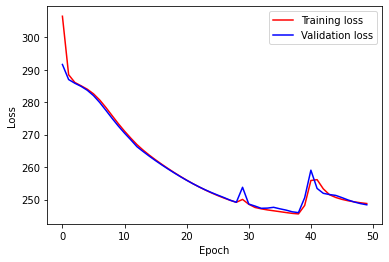

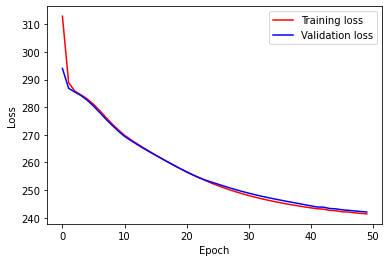

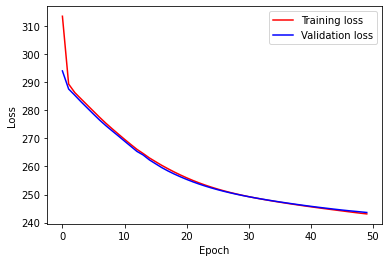

In [ ]:
hornn_test_results = {}
for seq_len in seq_lens:
    train_gen = data_generator(train_data, vocab_size, seq_len, batch_size)
    test_gen = data_generator(test_data, vocab_size, seq_len, batch_size)
    val_gen =  data_generator(valid_data, vocab_size, seq_len, batch_size)

    train_steps = len(train_data)//((seq_len+1)*batch_size)
    test_steps = len(test_data)//((seq_len+1)*batch_size)
    val_steps = len(valid_data)//((seq_len+1)*batch_size)

    hornn_test_results[seq_len] = {}
    for order in orders:
        hornn_test_results[seq_len][order] = {}
        test_loss_results, test_acc_results = [], []
        for n in range(num_exp):
            print(f'HORNN {order} Experiment: {n}; seq_len: {seq_len}')
            hornn_model = HORNN(hidden_size, input_size=vocab_size, out_size=vocab_size, order=order)
            hidden_state = np.zeros((hidden_size, 1))  # Initial hidden_state
            hornn_train_loss, hornn_valid_loss = hornn_model.train(train_set=train_gen, valid_set=val_gen, 
                                                    hidden_state=hidden_state, num_epochs=num_epochs, 
                                                    lr=learning_rate, clip_norm=gradient_clip_norm, 
                                                    train_steps=train_steps, val_steps=val_steps)
            hornn_test_loss, hornn_test_acc = hornn_model.test(test_set=test_gen, hidden_state=hidden_state, test_steps=test_steps)
            test_loss_results.append(hornn_test_loss)
            test_acc_results.append(hornn_test_acc)
            # Plot training and validation loss
            epoch = np.arange(len(hornn_train_loss))
            plt.figure()
            plt.plot(epoch, hornn_train_loss, 'r', label='Training loss',)
            plt.plot(epoch, hornn_valid_loss, 'b', label='Validation loss')
            plt.legend()
            plt.xlabel('Epoch'), plt.ylabel('Loss')
            plt.savefig(f'char_{seq_len}__hornn{order}_exp_{n}.png')
        
        print(f'Seq_len: {seq_len}; HORNN-{order} average char test loss: {np.average(test_loss_results)}')
        print(f'Seq_len: {seq_len}; HORNN-{order} average char test acc: {np.average(test_acc_results)}')
        hornn_test_results[seq_len][order]['loss'] = np.average(test_loss_results)
        hornn_test_results[seq_len][order]['acc'] = np.average(test_acc_results)
        hornn_test_results[seq_len][order]['all_loss'] = test_loss_results.copy()
        hornn_test_results[seq_len][order]['all_acc'] = test_acc_results.copy()